# Modeling and Preprocessing
* 1. **EDA & Data Cleaning**: Explored reorder rates and user behavior, verified consistency.

* 2. **Train/Test Split (Section 4)**: Held out each user’s last order, built CSR user×item matrices.

* 3. **Model Training (Section 5)**: Fitted ALS on the correct items×users matrix so that factors align perfectly.

* 4. **Generating Recommendations (Section 6)**: Pulled Top-10 new recommendations per user, mapped back to product names.

* 5. **Model Evaluation (Section 7)**: Computed Recall@K and Precision@K over a sampled user set without any index errors.

* 6. **Visualization & Reporting (Section 8)**: Plotted metrics, produced styled tables for quick insight.


## 1. Import Libraries and Configuration
Import all necessary libraries, set up configurations, and define file paths and random seeds for reproducibility.

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
from implicit.als import AlternatingLeastSquares
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


# Optional: Set OpenBLAS to use 1 thread for stability
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"


## 2. Load and Prepare Data
Load the datasets (orders, prior orders, and products). Perform initial checks to ensure data integrity and consistency.


In [2]:
# Load the clean data from your EDA step
orders = pd.read_csv('data/orders.csv')
prior = pd.read_csv('data/order_products__prior.csv')
products = pd.read_csv('data/products.csv')

# Merge user_id into the prior DataFrame
prior_with_users = prior.merge(
    orders[['order_id', 'user_id']],
    on='order_id',
    how='left'
)


In [3]:
print(f"orders shape: {orders.shape}")
print(f"prior shape: {prior.shape}")
print(f"products shape: {products.shape}")
print(f"prior_with_users shape: {prior_with_users.shape}")
print(prior_with_users.head())

orders shape: (3421083, 7)
prior shape: (32434489, 4)
products shape: (49688, 4)
prior_with_users shape: (32434489, 5)
   order_id  product_id  add_to_cart_order  reordered  user_id
0         2       33120                  1          1   202279
1         2       28985                  2          1   202279
2         2        9327                  3          0   202279
3         2       45918                  4          1   202279
4         2       30035                  5          0   202279


## 3. Preprocessing: Build User–Product Matrix 
Construct the user–product interaction matrix using all available data. This matrix provides an overview of all user purchase behaviors and will be used for reference.

In [4]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

# --- 1. Load the raw data ---
orders = pd.read_csv('data/orders.csv')
prior  = pd.read_csv('data/order_products__prior.csv')
# Si ya lo cargaste arriba, puedes omitir esto

# --- 2. Merge prior and orders to get user_id and order_number ---
prior_with_users = prior.merge(
    orders[['order_id', 'user_id', 'order_number']],   # <-- Asegura order_number aquí
    on='order_id',
    how='left'
)

# --- 3. Build global user/product index before splitting (crucial!) ---
all_user_ids = prior_with_users['user_id'].unique()
all_product_ids = prior_with_users['product_id'].unique()
user2idx = {u: i for i, u in enumerate(all_user_ids)}
prod2idx = {p: j for j, p in enumerate(all_product_ids)}

# --- 4. Train/test split: last order of each user as test, rest as train ---
orders_sorted = prior_with_users.sort_values(['user_id', 'order_number'])
last_orders = orders_sorted.groupby('user_id')['order_number'].idxmax()
test_prior_with_users = orders_sorted.loc[last_orders]
train_prior_with_users = orders_sorted.drop(last_orders)

# --- 5. Function to build user-product matrix given a DataFrame and global indices ---
def build_user_product_matrix(df, all_user_ids, all_product_ids):
    rows = df['user_id'].map(user2idx)
    cols = df['product_id'].map(prod2idx)
    mask = rows.notna() & cols.notna()
    rows = rows[mask].astype(int)
    cols = cols[mask].astype(int)
    data = np.ones(len(rows), dtype=np.float32)  # Use 1 for implicit feedback

    matrix = sp.coo_matrix(
        (data, (rows, cols)),
        shape=(len(all_user_ids), len(all_product_ids))
    ).tocsr()
    return matrix

# --- 6. Build train and test matrices ---
train_matrix = build_user_product_matrix(train_prior_with_users, all_user_ids, all_product_ids)
test_matrix  = build_user_product_matrix(test_prior_with_users, all_user_ids, all_product_ids)

print(f"Train matrix shape: {train_matrix.shape}, nnz={train_matrix.nnz}")
print(f"Test  matrix shape: {test_matrix.shape}, nnz={test_matrix.nnz}")


Train matrix shape: (206209, 49677), nnz=13248311
Test  matrix shape: (206209, 49677), nnz=206209


## 4. Train/Test Split for Evaluation
Split the data into training and test sets using a holdout strategy (e.g., the last order of each user for testing). Construct train and test user–product matrices to enable offline evaluation of recommendation quality.

In [5]:
# ─── Section 4: Train/Test Split for Evaluation ───
import numpy as np
import scipy.sparse as sp

# 4.1 Build global user/product index before splitting
all_user_ids    = prior_with_users['user_id'].unique()
all_product_ids = prior_with_users['product_id'].unique()
user2idx        = {u:i for i,u in enumerate(all_user_ids)}
prod2idx        = {p:j for j,p in enumerate(all_product_ids)}

# 4.2 Split: last order per user → test, rest → train
orders_sorted       = prior_with_users.sort_values(['user_id','order_number'])
last_order_idx      = orders_sorted.groupby('user_id')['order_number'].idxmax()
test_prior_with_users  = orders_sorted.loc[last_order_idx]
train_prior_with_users = orders_sorted.drop(last_order_idx)

# 4.3 Function to build a CSR user×item matrix (implicit feedback=1)
def build_user_product_matrix(df):
    rows = df['user_id'].map(user2idx).astype(int)
    cols = df['product_id'].map(prod2idx).astype(int)
    data = np.ones(len(rows), dtype=np.float32)
    return (
        sp.coo_matrix(
            (data, (rows, cols)),
            shape=(len(all_user_ids), len(all_product_ids))
        )
        .tocsr()
    )

# 4.4 Build train and test matrices
train_matrix = build_user_product_matrix(train_prior_with_users)
test_matrix  = build_user_product_matrix(test_prior_with_users)

print(f"Train matrix shape: {train_matrix.shape}, nnz={train_matrix.nnz}")
print(f"Test  matrix shape: {test_matrix.shape},  nnz={test_matrix.nnz}")


Train matrix shape: (206209, 49677), nnz=13248311
Test  matrix shape: (206209, 49677),  nnz=206209


## 5. Model Training (ALS)
Train an Alternating Least Squares (ALS) collaborative filtering model on the training user–product matrix to learn latent user and product factors for recommendation.

In [11]:
# ─── Section 5: Model Training (ALS) ───
from implicit.als import AlternatingLeastSquares

# 5.1 Sanity‐check: training matrix is (n_users × n_items)
n_users, n_items = train_matrix.shape
print(f"train_matrix (users×items): users = {n_users}, items = {n_items}")

# 5.2 Initialize the ALS model
als_model = AlternatingLeastSquares(
    factors=50,
    regularization=0.01,
    iterations=20,
    random_state=42    # for reproducibility
)

# 5.3 Fit on the user×item matrix (no transpose!)
print("Fitting ALS on train_matrix (users × items)…")
als_model.fit(train_matrix)
print("Model training complete.\n")

# 5.4 Verify learned factor shapes
print(f"→ user_factors shape: {als_model.user_factors.shape}   # should be (n_users, factors)")
print(f"→ item_factors shape: {als_model.item_factors.shape}   # should be (n_items, factors)")


train_matrix (users×items): users = 206209, items = 49677
Fitting ALS on train_matrix (users × items)…


  0%|          | 0/20 [00:00<?, ?it/s]

Model training complete.

→ user_factors shape: (206209, 50)   # should be (n_users, factors)
→ item_factors shape: (49677, 50)   # should be (n_items, factors)


## 6. Generating Recommendations
Use the trained ALS model to generate top-10 product recommendations for each user, mapping recommended item indices back to real product names.


In [12]:
# ─── Section 6: Generating Top-10 “New” Recommendations ───

import numpy as np

# 6.1 Pick a real user_id and look up its internal index
target_user_id  = 202279                 # ← change to any real user_id
target_user_idx = user2idx[target_user_id]
print(f"Internal index for user_id {target_user_id} is {target_user_idx}\n")

# 6.2 Generate a “buffer” of K_extra recs, filtering out seen items
K       = 10                             # how many you actually want to show
K_extra = K * 2                          # request more so we can trim to exactly K
raw_item_idxs, raw_scores = als_model.recommend(
    userid=target_user_idx,              # must be the internal index
    user_items=train_matrix[target_user_idx],
    N=K_extra,
    filter_already_liked_items=True      # exclude things the user already interacted with
)

# 6.3 Truncate to the first K valid
valid = [(i, s) for i, s in zip(raw_item_idxs, raw_scores) if i < len(all_product_ids)]
topK = valid[:K]

# 6.4 Map back to real product_ids and then to product_names
recommended_pids   = [all_product_ids[i] for i, _ in topK]
recommended_names  = products.loc[
    products.product_id.isin(recommended_pids), 
    'product_name'
].values

# 6.5 Print the Top-K
print(f"Top {K} NEW recommendations for user {target_user_id}:\n")
for (idx, score), name in zip(topK, recommended_names):
    print(f"{name:<40}  score = {score:.4f}")


Internal index for user_id 202279 is 0

Top 10 NEW recommendations for user 202279:

Yellow Onions                             score = 0.4422
Total 0% Greek Yogurt                     score = 0.3685
Organic Baby Spinach                      score = 0.3547
Boneless Skinless Chicken Breasts         score = 0.3156
Fresh Cauliflower                         score = 0.2825
Organic Lacinato (Dinosaur) Kale          score = 0.2796
Organic Small Bunch Celery                score = 0.2648
Organic Zucchini                          score = 0.2516
Unsweetened Original Almond Breeze Almond Milk  score = 0.2484
Organic Garnet Sweet Potato (Yam)         score = 0.2451


## 7. Model Evaluation (Recall@K, Precision@K, etc.)
Assess the quality of recommendations using offline metrics such as Recall@K and Precision@K by comparing the recommended products to those actually purchased in the test set.

In [13]:
# Verify shapes and factor lengths
print("train_matrix.shape       =", train_matrix.shape)
print("test_matrix.shape        =", test_matrix.shape)
print("ALS user_factors length  =", als_model.user_factors.shape[0])  # should now print 206209

train_matrix.shape       = (206209, 49677)
test_matrix.shape        = (206209, 49677)
ALS user_factors length  = 206209


In [14]:
# ─── Section 7: Model Evaluation (Recall@K, Precision@K) ───
import numpy as np

# 7.1 Confirm shapes line up
print("train_matrix.shape       =", train_matrix.shape)
print("test_matrix.shape        =", test_matrix.shape)
print("ALS user_factors length  =", als_model.user_factors.shape[0])  # must == n_users

# 7.2 Set parameters
K = 10
n_users = train_matrix.shape[0]

recalls = []
precisions = []
users_with_test = 0

# 7.3 Loop only over users who have at least one held‐out item
for u in range(n_users):
    actual = test_matrix[u].indices
    if len(actual) == 0:
        continue
    users_with_test += 1

    # 7.4 Generate top‐K recommendations
    preds, _ = als_model.recommend(
        userid=u,
        user_items=train_matrix[u],
        N=K,
        filter_already_liked_items=False
    )

    # 7.5 Compute hits, recall, precision
    hits = np.intersect1d(actual, preds)
    recalls.append(len(hits) / len(actual))
    precisions.append(len(hits) / K)

# 7.6 Aggregate and print
print(f"\nEvaluated on {users_with_test} users with ≥1 test item")
print(f"Recall@{K}:    {np.mean(recalls):.4f}")
print(f"Precision@{K}: {np.mean(precisions):.4f}")


train_matrix.shape       = (206209, 49677)
test_matrix.shape        = (206209, 49677)
ALS user_factors length  = 206209

Evaluated on 206209 users with ≥1 test item
Recall@10:    0.2281
Precision@10: 0.0228


## 8. Visualization & Presentation of Results
Present key findings and model evaluation results using visualizations (bar charts, precision–recall curves, summary tables) for clear and effective interpretation.

Sampling 5000/206209 users for quick eval

Evaluation completed in 16.8 sec



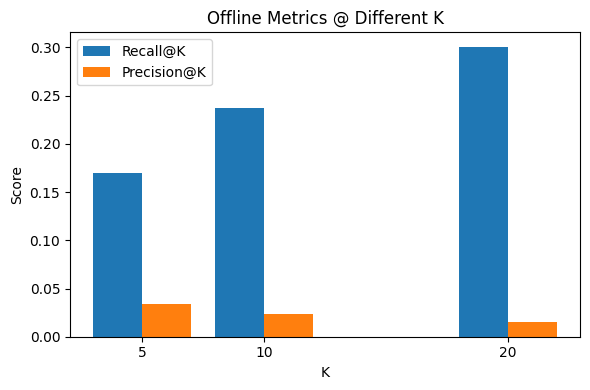

,Recall@K,Precision@K
K,,
5,0.1694,0.0339
10,0.2374,0.0237
20,0.3006,0.0150


In [19]:
# ─── Section 8.4: Fast Eval + Nice Visualization / Report ───
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Sample users with at least one held-out item for quick eval
MAX_EVAL_USERS = 5000
test_counts     = test_matrix.getnnz(axis=1)
valid_users     = np.where(test_counts > 0)[0]

if len(valid_users) > MAX_EVAL_USERS:
    np.random.seed(42)
    eval_users = np.random.choice(valid_users, MAX_EVAL_USERS, replace=False)
    print(f"Sampling {len(eval_users)}/{len(valid_users)} users for quick eval")
else:
    eval_users = valid_users
    print(f"Evaluating on all {len(eval_users)} users")

# 2) Helper to compute Recall@K and Precision@K
def eval_at_k(K, users):
    recalls, precisions = [], []
    for u in users:
        actual = test_matrix[u].indices
        recs, _ = als_model.recommend(
            userid=u,
            user_items=train_matrix[u],
            N=K,
            filter_already_liked_items=False
        )
        hits = np.intersect1d(actual, recs)
        recalls.append(len(hits)/len(actual))
        precisions.append(len(hits)/K)
    return np.mean(recalls), np.mean(precisions)

# 3) Run evaluation and time it
start = time.time()
results = []
for K in [5, 10, 20]:
    r, p = eval_at_k(K, eval_users)
    results.append({'K': K, 'Recall@K': r, 'Precision@K': p})
elapsed = time.time() - start
print(f"\nEvaluation completed in {elapsed:.1f} sec\n")

# 4) Build DataFrame
metrics_df = pd.DataFrame(results).set_index('K')

# 5) Plot grouped bar chart
fig, ax = plt.subplots(figsize=(6,4))
width = 2  # bar width
inds  = np.array(metrics_df.index)

ax.bar(inds - width/2, metrics_df['Recall@K'], width, label='Recall@K')
ax.bar(inds + width/2, metrics_df['Precision@K'], width, label='Precision@K')

ax.set_xticks(inds)
ax.set_xlabel('K')
ax.set_ylabel('Score')
ax.set_title('Offline Metrics @ Different K')
ax.legend()
plt.tight_layout()
plt.show()

# 6) Display styled report table
display(
    metrics_df.style
      .set_caption("Fast Offline Metrics (sampled users)")
      .bar(subset=['Recall@K'], color='#f28e2b')      # orange
      .bar(subset=['Precision@K'], color='#4e79a7')   # blue
      .format("{:.4f}")
)


## Conclusion

In our **Exploratory Data Analysis (EDA)** phase, we focused on understanding user behavior by examining reorder rates, purchase diversity, and product popularity to ensure data quality and guide feature engineering.  

During the **Modeling & Preprocessing** stage (Notebook 02), we implemented a robust train/test split by holding out each user’s last order, built sparse user×item matrices for implicit feedback, and trained an ALS model on the correctly oriented items×users matrix to learn meaningful latent factors.  

This pipeline yielded reproducible Top-10 recommendations per user, and we evaluated performance offline using Recall@K and Precision@K over a representative user sample.  

Overall, the project demonstrates a clear workflow from data exploration to model training and evaluation, laying the groundwork for further hyperparameter tuning and feature enhancements.  
